In [1]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
# for testing on GPU
#os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Dense
from keras.utils import np_utils
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 30, 30

train_data_dir = 'DITS-classification/classification train'
test_data_dir = 'DITS-classification/classification test'
nb_train_samples = 7489
nb_test_samples = 1159
epoche = 30
batch_size = 128
split_per_validazione=0.15

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=split_per_validazione,
    #rotation_range=20,
    #width_shift_range=0.05,
    #height_shift_range=0.05,
    #fill_mode="nearest",
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255.)

In [3]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=int(nb_train_samples*(1-split_per_validazione)),
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=int(nb_train_samples*split_per_validazione),
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=nb_test_samples,
    class_mode="categorical")

X_train = train_generator[0][0]
Y_train = train_generator[0][1]
X_validation = validation_generator[0][0]
Y_validation = validation_generator[0][1]
X_test = test_generator[0][0]
Y_test = test_generator[0][1]

Found 6387 images belonging to 59 classes.
Found 1102 images belonging to 59 classes.
Found 1159 images belonging to 59 classes.


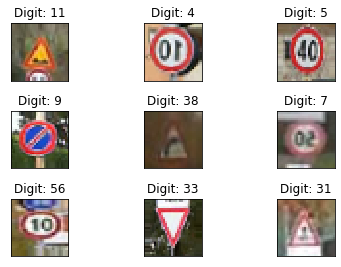

In [4]:
#Stampa di alcuni esempi con le relative digits
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(np.where(Y_test[i]==1)[0][0]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [5]:
#Operazioni la stampa finale
y_test = np.empty(len(Y_test),dtype=int)
for j in range(len(Y_test)):
    #print(j, "/", len(Y_test), end='\r')
    y_test[j]=(np.where(Y_test[j]==1)[0][0])

#Quest'ultima cosa serve per la stampa finale
immaginiPerLaStampaFinale=X_test

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
[ 26  13  50 534 166  39  64  26  26  64  13 203  25  13 356  39 280  13
 278 217 278  26 216  64  77 179  13  51 153  26  64 177  89  51 177 217
 115 267  90  26 395  49  12  13 382  77  39  26  13  25  13  39  50  26
  26  51 200  13 115]


In [6]:
# building a linear stack of layers with the sequential model
def prepare_model():
    model = Sequential()
    model.add(Conv2D(128,kernel_size=(7, 7),activation='relu',input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128,kernel_size=(5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128,kernel_size=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(layers.Dense(59, activation='relu'))
    model.add(layers.Dense(59, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [7]:
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
checkpoint_filepath = '/tmp/checkpoint'
epocheSalvataggio=10
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, save_weights_only=True,
        monitor='val_loss', save_freq=epocheSalvataggio,
        save_best_only=True)

callback = [ TensorBoard(update_freq=521),
                EarlyStopping(monitor='val_accuracy', patience=2),
                ModelCheckpoint("HW5Conv-EarlyStopping.h5", save_best_only=True), ]

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


Train on 6365 samples, validate on 1102 samples
Epoch 1/30
6365/6365 - 14s - loss: 3.5434 - accuracy: 0.1137 - val_loss: 3.0219 - val_accuracy: 0.2033
Epoch 2/30
6365/6365 - 13s - loss: 2.7199 - accuracy: 0.2861 - val_loss: 2.4355 - val_accuracy: 0.3575
Epoch 3/30
6365/6365 - 14s - loss: 2.1401 - accuracy: 0.4299 - val_loss: 1.9539 - val_accuracy: 0.4755
Epoch 4/30
6365/6365 - 14s - loss: 1.6383 - accuracy: 0.5351 - val_loss: 1.7839 - val_accuracy: 0.5100
Epoch 5/30
6365/6365 - 13s - loss: 1.3039 - accuracy: 0.6141 - val_loss: 1.5533 - val_accuracy: 0.5526
Epoch 6/30
6365/6365 - 14s - loss: 1.0624 - accuracy: 0.6771 - val_loss: 1.3452 - val_accuracy: 0.6007
Epoch 7/30
6365/6365 - 14s - loss: 0.8750 - accuracy: 0.7296 - val_loss: 1.2561 - val_accuracy: 0.6143
Epoch 8/30
6365/6365 - 14s - loss: 0.7324 - accuracy: 0.7723 - val_loss: 1.1959 - val_accuracy: 0.6543
Epoch 9/30
6365/6365 - 14s - loss: 0.6146 - accuracy: 0.8031 - val_loss: 1.1895 - val_accuracy: 0.6543
Epoch 10/30
6365/6365 - 1

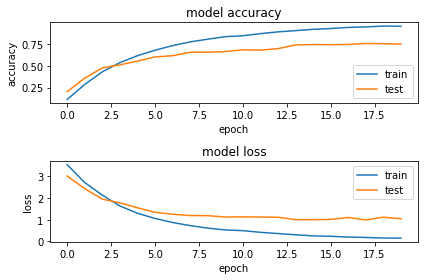

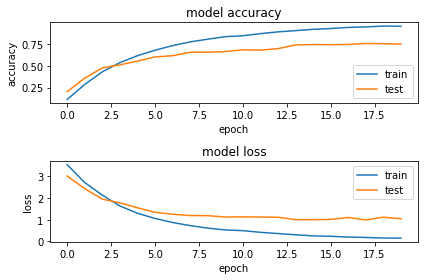

In [8]:
model = prepare_model()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epoche,
                    verbose=2,
                    validation_data=(X_validation, Y_validation),
                    callbacks=callback)


# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [9]:
save_dir = "results/"
model_name = 'HW5Conv-EarlyStopping.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at results/HW5Conv-EarlyStopping.h5 


In [10]:
modello_cartelli = load_model("results/HW5Conv-EarlyStopping.h5")
loss_and_metrics = modello_cartelli.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

1159/1159 - 2s - loss: 2.9324 - accuracy: 0.5910
Test Loss 2.932421035865343
Test Accuracy 0.5910267



685  classified correctly
474  classified incorrectly


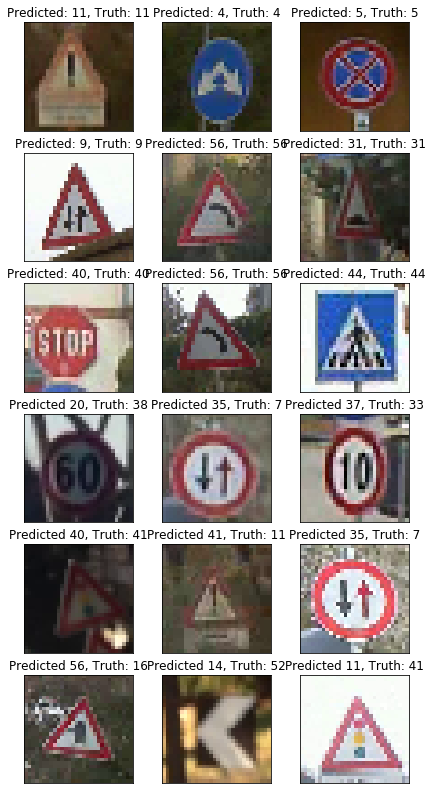

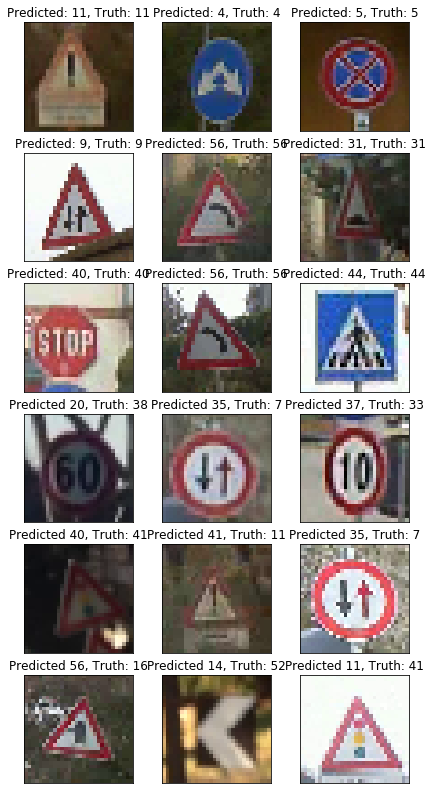

In [11]:
# Creazione delle predizioni sul test set sulla base del modello caricato
carica_model = load_model('results/HW5Conv-EarlyStopping.h5')
predicted_classes = carica_model.predict_classes(X_test)

# Distinguo cosa è stato predetto bene e cosa no
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# Stampa delle 9 predizioni corrette
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(immaginiPerLaStampaFinale[correct], interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])
    
# Stampa delle 9 predizioni incorrette
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(immaginiPerLaStampaFinale[incorrect], interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation